In [1]:
# imports 

# make notebook span full width of window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib.pyplot as plt
%matplotlib inline

import os
path_base = os.getcwd().split('Dragonfly44_SFH')[0] + "Dragonfly44_SFH/" # hack, but works
path_fits = path_base+ "fitting/output/fits/"

path_data = path_base+ "data/"
file_data = path_data+"DF44/obs_phot_specKCWI_sigma110.h5"

import numpy as np

from Dragonfly44_SFH.utils import prospect_io, plotting, transforms
from figure_style import *

In [2]:
label0 = "SFH prior:" # label which related to label1, label2

# contains filenames of Prospector output
from Dragonfly44_SFH.fitting.output.fits.fits_DF44_summary import *

result_file1 = path_fits+ fit_aD1_phot_specKCWI
label1 = 'Extended'
color1 = color_aD1
result1, obs1, model1 = prospect_io.read_results( result_file1, file_data=file_data )

result_file2 = path_fits+ fit_aD02_phot_specKCWI
label2 = 'Concentrated'
color2 = color_aD02
result2, obs2, model2 = prospect_io.read_results( result_file2, file_data=file_data )

zobs = float(model1.params['zred'])



In [4]:
# setup styling

obs_params1 = {'marker':'o', 'color':'k', 'ms':20}
obs_params2 = obs_params1

posts_params1={'color':color1}
posts_params2={'color':color2}

bestfit_params1 = marker_params_aD1
bestfit_params2 = marker_params_aD02

plot_params1 = dict( obs=obs1, result=result1, zobs=zobs, label=label1,
                     obs_params=obs_params1, posts_params=posts_params1, bestfit_params=bestfit_params1 )

plot_params2 = dict( obs=obs2, result=result2, zobs=zobs, label=label2,
                     obs_params=obs_params2, posts_params=posts_params2, bestfit_params=bestfit_params2 )


In [5]:
showpars = ['dust2','Av','logzsol','logmass_stellar',"mwa"]
labels = [
          r"$\hat{\tau}_\mathrm{dust,~diffuse}$",\
          r"$*A_\mathrm{V}$",\
          r"$\log(~Z_\ast/\mathrm{Z}_\odot~)$",\
          r"*$\log(~M_{\ast}/\mathrm{M}_\odot~)$",\
          r"*$t_\mathrm{mass}$ (Gyr)",\
        ]
bin_ranges = [[0,0.5], [-0.2,1], [-1.35,-1.1], [8.1,8.5], [9,13.5]]


In [6]:
if True: # corner setup
    from corner.core import _set_xlim,_set_ylim,hist2d,_get_fig_axes
    from matplotlib.ticker import MaxNLocator, NullLocator, ScalarFormatter, MultipleLocator
    from matplotlib.legend_handler import HandlerTuple
    from scipy.ndimage import gaussian_filter
    from prospect.sources.constants import cosmo # In my case WMAP9

    whspace = 0.05  # w/hspace size
    

if True: # corner params *********** 
    K3, K2 = 0, 0
    labelpad = 0.13
    fig_width = fig_width_one

    
    K = len(showpars)
    factor = 1
    lbdim = 0.5 * factor  # size of left/bottom margin
    trdim = 0.2 * factor  # size of top/right margin
    plotdim = factor * K + factor * (K - 1.0) * whspace
    dim = lbdim + plotdim + trdim
    lb = lbdim / dim
    tr = (lbdim + plotdim) / dim

    dim2 = factor * K2 + factor * (K2 - 1.0) * whspace
    dim3 = factor * K3 + factor * (K3 - 1.0) * whspace
    
    hist_bin_factor = np.full( K, 1.)
    bins = np.full( K, 20).astype(int)

    hist_kwargs = dict()
    hist2d_kwargs = dict( quiet=False,
                            plot_datapoints=1,
                            plot_density=1,
                            plot_contours=1,
                            no_fill_contours=0,
                            fill_contours=False,
                            contour_kwargs=None,
                            contourf_kwargs=None,
                            data_kwargs=None,
                            pcolor_kwargs=None )



In [7]:
# values for DF44 from literature for comparison
truths_from_lit = {
                  "logmass_stellar": np.log10(3e8), # van Dokkum
                  "logmass": np.log10(3e8)+0.25, # rough approx of mass loss
                 }

if True: #v22 logzsol 
    # Villaume+2021 logzsol
    # I'm pretty sure that the metallicity you get from fsps/prospector is the "isochrone" metallicity from alf, which is not what I quote in my paper. 
    # I'm attaching the posterior of isochrone metallicity from my alf fit to DF44 so you can remake that comparison.
    file_data_V22_Z = path_data+'DF44/Villaume2022_KCWI/df44_zh_posterior_for_kristi_10_12_2021.dat'
    villaume2021_logzsol = np.loadtxt( file_data_V22_Z, unpack=1)
    qs_villaume2021_logzsol = np.quantile(villaume2021_logzsol, [0.16,0.5,0.84])
    truths_from_lit["logzsol"] = qs_villaume2021_logzsol[1]
    
if True: # S44 logmass
    x = 2.1e8
    ex = 0.5e8
    y = np.log10(x)
    ey = ex/x/np.log(10)
    qs_saifolahi2022_logmass = ( y-ey, y, y+ey )
    truths_from_lit["logmass_stellar_s22"] = qs_saifolahi2022_logmass[1]



In [8]:
# Format the quantile display.
title_fmt = ".2f"
fmt = "{{0:{0}}}".format(title_fmt).format
title = r"${{{0}}}_{{-{1}}}^{{+{2}}}$"

from Dragonfly44_SFH.utils.misc_utils import weighted_quantile
from Dragonfly44_SFH.utils.transforms import chain_to_param

qnt_titles = {}
for i,result in enumerate([ result1, result2 ]):
    qnt_titles[str(i)] = {}
    
    for j,par in enumerate( showpars ):
        x = chain_to_param( param=par, **result )
        x = np.squeeze(x)
        q_16, q_50, q_84 = weighted_quantile( x, [0.16, 0.5, 0.84], result['weights'] )
        q_m, q_p = q_50 - q_16, q_84 - q_50
        qnt_titles[str(i)][par] = title.format(fmt(q_50), fmt(q_m), fmt(q_p))


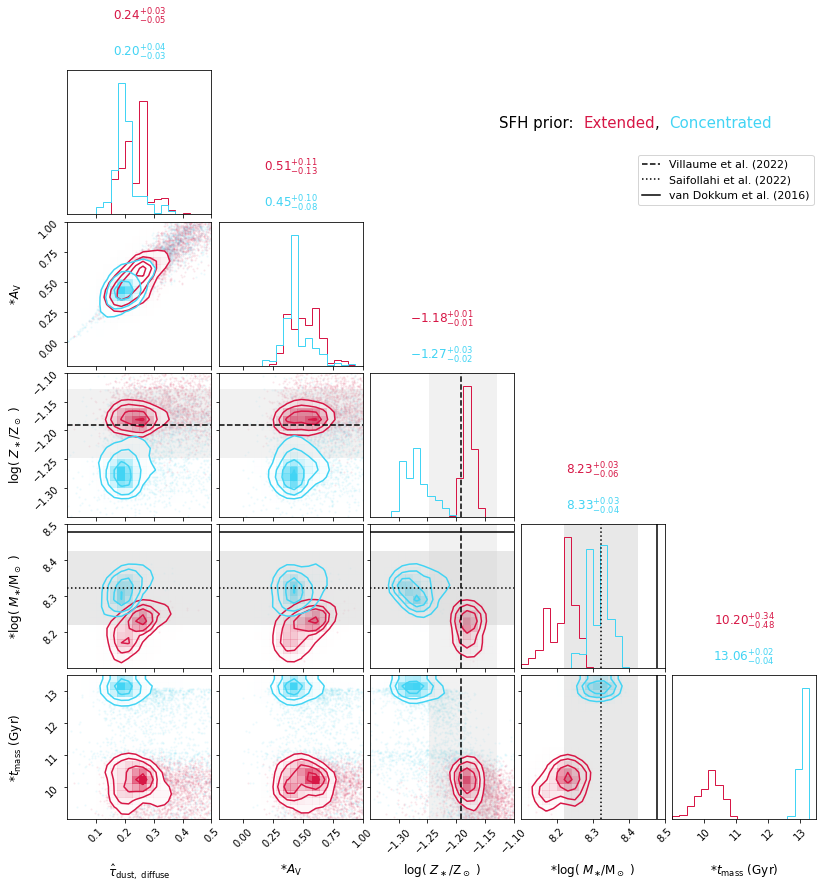

In [9]:
xparams = dict( labels=labels, smooth=1, range=bin_ranges, bins=bins, quantiles=[], 
                hist2d_kwargs=hist2d_kwargs, 
              )
params = dict( showpars=showpars, smooth=1, show_titles=1, label=labels, return_fig=1, 
               figsize=(dim+dim2,dim+dim3),
               xparams=xparams )

fig = plotting.plot_corner( result1, color=color1, **params  )
fig = plotting.plot_corner( result2, color=color2, fig=fig, **params  )

axes = fig.get_axes()
ndim = len(showpars)
axes = np.array(axes).reshape(ndim,ndim)
K3 = 0

if True: # labels 

    annparams = dict( fontsize=15 )   
    string_list = [ label0+'  ', label1, ',  ', label2]
    scolor_list = ['k',color1,'k', color2]
    x0,y0 = -0.15,0.6
    plotting.multicolor_text( axes[0,3] , fig, x0,y0, string_list, scolor_list, **annparams )

if True: # truths 
#     plotting.overplot_lines_2(axes[K3:,:K], truths, colors=col_truths, ls='-')
    
    for i,par in enumerate(showpars):
        if par=='logzsol':
            for ax in axes[K3+i,:i]:
                ax.axhline( qs_villaume2021_logzsol[1], color='k', ls='--' )
                ax.axhspan( qs_villaume2021_logzsol[0], qs_villaume2021_logzsol[2], color='lightgrey', alpha=0.3, lw=0 )
            for ax in axes[K3+i:,i]:
                ax.axvline( qs_villaume2021_logzsol[1], color='k', ls='--' )
                ax.axvspan( qs_villaume2021_logzsol[0], qs_villaume2021_logzsol[2], color='lightgrey', alpha=0.3, lw=0 )
            
        if par=='logmass_stellar':
            for ax in axes[K3+i,:i]:
                ax.axhline( truths_from_lit["logmass_stellar"], color='k', ls='-',  )
                ax.axhline( qs_saifolahi2022_logmass[1], color='k', ls=':',  )
                ax.axhspan( qs_saifolahi2022_logmass[0], qs_saifolahi2022_logmass[2], color='lightgrey', alpha=0.5, lw=0 )
            for ax in axes[K3+i:,i]:
                ax.axvline( truths_from_lit["logmass_stellar"], color='k', ls='-' )
                ax.axvline( qs_saifolahi2022_logmass[1], color='k', ls=':' )
                ax.axvspan( qs_saifolahi2022_logmass[0], qs_saifolahi2022_logmass[2], color='lightgrey', alpha=0.5, lw=0 )
           
    ax = axes[1,-1]
    ax.plot( [],[], color='k', ls='--', label="Villaume et al. (2022)")
    ax.plot( [],[], color='k', ls=':', label="Saifollahi et al. (2022)")
    ax.plot( [],[], color='k', ls='-', label="van Dokkum et al. (2016)")
    ax.legend( loc=1, handlelength=1.6, fontsize=11, bbox_to_anchor=[1.02,1.5] )    
    
for i,par in enumerate(showpars): # qnt titles
    ax = axes[i+K3, i]                
#     ax.set_ylim(0, np.max(ymaxs[i,:])*1.05 )
    
    ann_params = dict( xy=(0,0), xycoords='axes fraction', ha='center', va='bottom')
    
    ax.annotate( qnt_titles['0'][par], xytext=(0.5,1.3),  color=color1, **ann_params )
    ax.annotate( qnt_titles['1'][par], xytext=(0.5,1.05), color=color2, **ann_params )
        
    
plt.savefig('figures/fig5.pdf', **saveparams)    
plt.show()